# Исследование данных о продажах игр в онлайн магазине "Стримчик"

---
    
## Описание проекта
      
### Дано:
    
Исторические данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation)

---
    
### Задача:
Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

---
### Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


Данные за 2016 год могут быть неполными.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

--- 

### Краткий план работы:
 - Подготовить данные для анализа
 - Найти актуальный период исчезновения старых и появления новых платформ для построения прогноза на 2017 год
 - Изучить, как влияют оценки игр на сумму их продаж
 - Для каждого региона определить ТОП5 самых популярных платформ
 - Проверить гипотезы

<div style="border:solid  red  1px; padding: 5px"> 
В данной работе выводы обведены красной рамкой

In [23]:
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
plt.style.use('seaborn-deep')
pd.options.mode.chained_assignment = None

### Шаг 1. Открываем файл с данными и изучаем  общую информацию. 

In [24]:
games = pd.read_csv('/datasets/games.csv')
display(games)
games.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Шаг 2. Подготовка данных 

In [25]:
def change_rating_name(data):
    """
    функция меняет знаения рейтинга ассоциации ESRB на понятные по обозначению возрастные ограничения
    """
    if (data=='E') or (data == 'K-A'):
        return '0+'
    if (data=='EC'):
        return '3+'
    if (data=='T'): 
        return '10+'
    if (data=='M'):
        return '13+'
    if (data=='AO'):
        return '18+'
    else:
        return np.nan


In [26]:
games.columns = [x.lower() for x in games.columns]#приводим названия столбцов к нижнему регистру
games = games.assign(#обрабатываем столбцы в наших данных
year_of_release = lambda x: x['year_of_release'].astype('Int64'),
critic_score  = lambda x: x['critic_score'].astype('Int64'),
rating = lambda x: x['rating'].fillna(0).apply(change_rating_name),
sum_of_sales = lambda x: (x['na_sales'] + x['eu_sales'] + x['jp_sales'] + x['other_sales']),
name = lambda x: x['name'].fillna('Без названия'),
genre = lambda x: x['genre'].fillna('Без названия'),
user_score = lambda x: pd.to_numeric(x['user_score'],errors='coerce'))

In [27]:
display(games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_of_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,0+,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,0+,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,0+,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


<div style="border:solid  red  1px; padding: 5px"> 

Проведена предобработка данных:
- названия столбцов приведены к нижнему регистру
- в столбцах `year_of_release` и  `critic_score` тип данных изменён на целочисленный, но пропуски оставлены, так как сложно найти подходящую замену, вносить искажение в данные не стоит
- тип данных в столбце `user_score` изменён на числовой, значения "tbd" говорят нам, что рейтинг пока не сформирован, но появится в будущем, в связи с этим принято решения заменить эти значения на пустые, ведь предугадать какими они будут сложно
- в столбце `rating` произведена замена значений по классификации ассоциации на читаемые возрастные ограничения 

Предполагаю, что причиной имеющихся пропусков в столбцах с рейтингом является действительное отсутсвие оценки игры пользователями, экспертами на той платформе, с которой брались данные


Добавлены новые столбцы:
- в `sum_of_sales` добавлены значения суммы продаж по всем регионам

### Шаг 3.  Исследовательский анализ данных

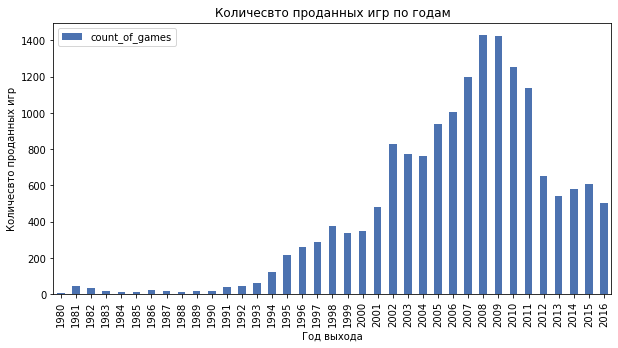

In [28]:
count_games = games.groupby('year_of_release').agg(
    count_of_games = pd.NamedAgg(column = 'platform',aggfunc  = 'count')).\
    plot(y = 'count_of_games', kind = 'bar', figsize = (10,5))
plt.title("Количесвто проданных игр по годам")
plt.xlabel("Год выхода")
plt.ylabel("Количесвто проданных игр")
plt.show()

<div style="border:solid  red  1px; padding: 5px"> 

 Мы видим, что до **1994** года продавалось относительно мало игр, поэтому для части исследования возьмём только игры, которые вышли позже - возьмём срез по годам и сохраним данные в новой переменной `games_new`

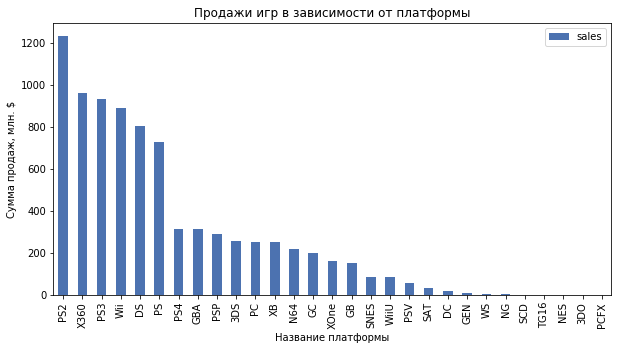

In [29]:
games_new = games.query('year_of_release > 1993')

sales_by_platform = games_new.groupby(['platform']).agg(
    sales = pd.NamedAgg(column = 'sum_of_sales',aggfunc  = 'sum')).reset_index().\
    sort_values(by = 'sales',ascending = False)

sales_by_platform.plot(x = 'platform',y = 'sales', kind = 'bar', figsize = (10,5))
plt.title("Продажи игр в зависимости от платформы")
plt.ylabel("Сумма продаж, млн. $")
plt.xlabel("Название платформы")
plt.show()

<div style="border:solid  red  1px; padding: 5px"> 
Благодаря полученной диаграмме выделим платформы с наибольшим количеством продаж. 

In [30]:
most_popular_platform = sales_by_platform.query('sales > 600')['platform']#выделяем названия платформ по срезу 
                                                                          #в отдельный список

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1994,NaN,6.03,NaN,NaN,NaN,NaN
1995,NaN,35.96,NaN,NaN,NaN,NaN
1996,NaN,94.70,NaN,NaN,NaN,NaN
1997,NaN,136.17,NaN,NaN,NaN,NaN
1998,NaN,169.49,NaN,NaN,NaN,NaN
1999,NaN,144.53,NaN,NaN,NaN,NaN
2000,NaN,96.37,39.17,NaN,NaN,NaN
2001,NaN,35.59,166.43,NaN,NaN,NaN
2002,NaN,6.67,205.38,NaN,NaN,NaN


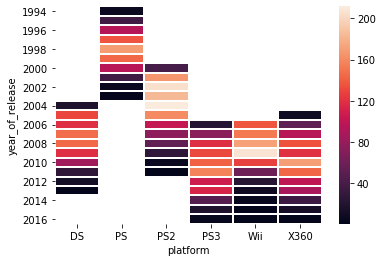

In [31]:
games_pivot = games_new.query('platform in @most_popular_platform').\
pivot_table(index = 'year_of_release', columns = 'platform', values = 'sum_of_sales', aggfunc = 'sum')

display(games_pivot)

sns.heatmap(games_pivot,linecolor='white',linewidths=1);#с помощью библиотеки seaborn строим тепловое распределение
#years = games_pivot.index.to_list()

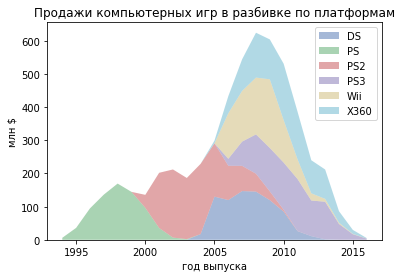

In [32]:
x = games_pivot.index.to_list()
y1 = games_pivot['DS'].fillna(0).to_list()
y2 = games_pivot['PS'].fillna(0).to_list()
y3 = games_pivot['PS2'].fillna(0).to_list()
y4 = games_pivot['PS3'].fillna(0).to_list()
y5 = games_pivot['Wii'].fillna(0).to_list()
y6 = games_pivot['X360'].fillna(0).to_list()

labels = games_pivot.columns.to_list()

fig, ax = plt.subplots()
ax.stackplot(x, y1, y2, y3,y4,y5,y6, alpha = 0.5, labels=labels)
ax.legend(loc='upper left')
ax.set(xlabel='год выпуска',
       ylabel='млн $',
       title='Продажи компьютерных игр в разбивке по платформам')
ax.legend(loc='upper right')
plt.show()




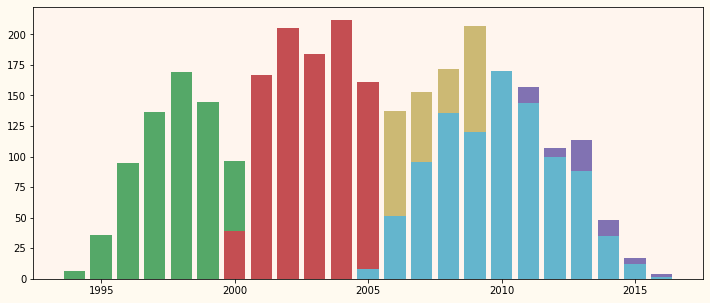

In [33]:
%matplotlib inline

fig, ax = plt.subplots()
ax.bar(x, y1)
ax.bar(x, y2)
ax.bar(x, y3)
ax.bar(x, y4)
ax.bar(x, y5)
ax.bar(x, y6)
ax.set_facecolor('seashell')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(5)    #  высота Figure
fig.set_facecolor('floralwhite')

plt.show()

In [34]:
#строим такую же диаграмму с помощью библиотеки plotly
fig = go.Figure(data=[
    go.Bar(name='DS', x=games_pivot[games_pivot['DS'].isna()==False].index, y=games_pivot[games_pivot['DS'].isna()==False]['DS']),
    go.Bar(name='PS', x= games_pivot[games_pivot['PS'].isna()==False].index, y=games_pivot[games_pivot['PS'].isna()==False]['PS']),
    go.Bar(name='PS2', x= games_pivot[games_pivot['PS2'].isna()==False].index, y=games_pivot[games_pivot['PS2'].isna()==False]['PS2']),
    go.Bar(name='PS3', x= games_pivot[games_pivot['PS3'].isna()==False].index, y=games_pivot[games_pivot['PS3'].isna()==False]['PS3']),
    go.Bar(name='Wii', x= games_pivot[games_pivot['Wii'].isna()==False].index, y=games_pivot[games_pivot['Wii'].isna()==False]['Wii']),
    go.Bar(name='X360', x= games_pivot[games_pivot['X360'].isna()==False].index, y=games_pivot[games_pivot['X360'].isna()==False]['X360'])
])

fig.update_layout(barmode='stack')
fig.show()

<div style="border:solid  red  1px; padding: 5px"> 
    
Построив распределения продаж по годам и платформам разными способами, можно выделить характерный срок исчезновения старых и появления новых платформ - *5 лет*. 

Для дальнейшего анализа сделаем срез по последним пяти годам.

In [35]:
games_analyze = games.query('year_of_release > 2011 and year_of_release < 2017 ')
pivot_analyze = games_analyze.pivot_table(index = 'year_of_release', 
                                          columns = 'platform', 
                                          values = 'sum_of_sales', 
                                          aggfunc = 'sum')#делаем сводную таблицу для выявления потенциально прибыльных платформ
display(pivot_analyze)


platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


<div style="border:solid  red  1px; padding: 5px"> 

Исходя из динамики продаж, самыми прибыльными могут быть платформы `PS4`,`XOne`,`3DS`.

Но нет новой платформы, у которой потенциально могли бы начать расти продажи в будущем.

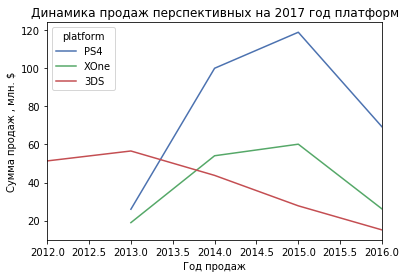

In [36]:
pivot_analyze.plot(y = ['PS4','XOne','3DS'])
plt.title('Динамика продаж перспективных на 2017 год платформ')
plt.xlabel('Год продаж')
plt.ylabel('Сумма продаж , млн. $')
plt.show()

<div style="border:solid  red  1px; padding: 5px"> 

Несмотря на резкое падение продаж платформы `PS4` за предыдущий год, можно предположить, что её продаж в 2017 году будет по-прежнему больше, чем конкурентов

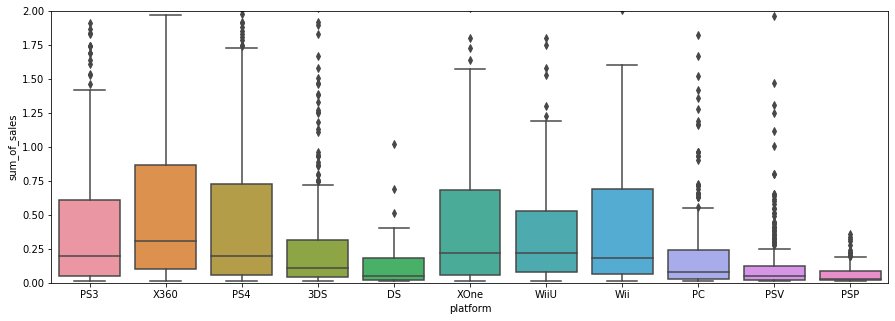

In [37]:
plt.figure(figsize = (15,5))
sns.boxplot(x="platform", y=games_analyze[games_analyze["sum_of_sales"].isna()==False]['sum_of_sales'], data=games_analyze);
plt.ylim(0, 2)
plt.show()
#games_analyze.boxplot(by = 'platform',column="sum_of_sales")

<div style="border:solid  red  1px; padding: 5px"> 
    
Исходя из построеннных диаграмм размаха для разных платформ, можно сделать вывод, что медианное значение продаж не сильно отличается, но вот среднее сзначение будет однозначно разным.

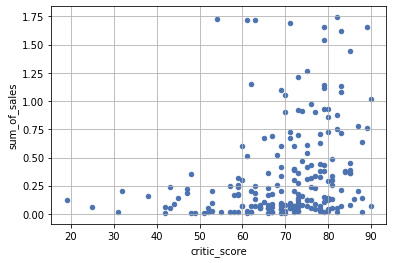

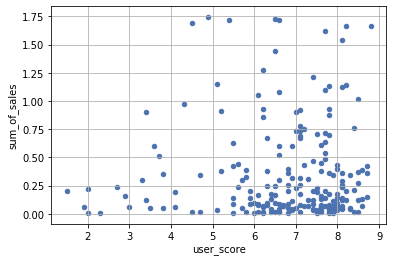

Зависимость суммы продаж платформы PS4 от оценки экспертов 0.31

Зависимость суммы продаж платформы PS4 от оценки пользователей 0.004


In [38]:
critic_analyze = games_analyze.query('platform == "PS4" and sum_of_sales<1.75 ')#делаем срез по платформе без выбросов

critic_analyze.plot(y = 'sum_of_sales', x = 'critic_score', kind='scatter', grid = True)
critic_analyze.plot(y = 'sum_of_sales', x = 'user_score', kind = 'scatter', grid = True)
plt.show()

print("Зависимость суммы продаж платформы PS4 от оценки экспертов {:.2f}". 
      format(games_analyze['sum_of_sales'].corr(games_analyze['critic_score'].astype('float'))))
print()

print("Зависимость суммы продаж платформы PS4 от оценки пользователей {:.3f}".
      format(games_analyze['sum_of_sales'].corr(games_analyze['user_score'])))

<div style="border:solid  red  1px; padding: 5px"> 
    
Исходя из полученных результатов, можно сделать вывод для платформы **PS4**:
- между экспертной оценкой игры и количеством продаж есть зависимость, но слабая
- обращать внимание на оценку пользователей вообще не стоит, низкая оценка пользователя никак не означает малое число продаж 

,sum_of_sales
genre,
Action,441.12
Shooter,304.73
Role-Playing,192.80
Sports,181.07
Misc,85.04
Platform,61.00
Racing,53.50
Fighting,44.49
Simulation,35.12


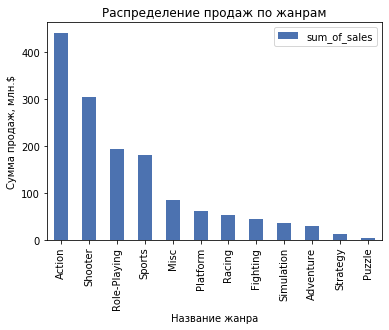

In [39]:
genre_analyze = games_analyze.groupby('genre').agg(
    sum_of_sales = pd.NamedAgg(column = 'sum_of_sales', aggfunc = 'sum')).\
    sort_values(by = 'sum_of_sales',ascending = False)
genre_analyze.plot(y = 'sum_of_sales', kind = 'bar')
plt.title('Распределение продаж по жанрам')
plt.xlabel('Название жанра')
plt.ylabel('Сумма продаж, млн.$')
genre_analyze
#genre_analyze = genre_analyze.query('')

<div style="border:solid  red  1px; padding: 5px"> 
    

Самый прибыльный жанр - `action` резко выделяется на фоне остальных, при этом сумма продаж
наименее популярного жанра `puzzle` примерно **в 100 раз** меньше, это очень огромная разница.    

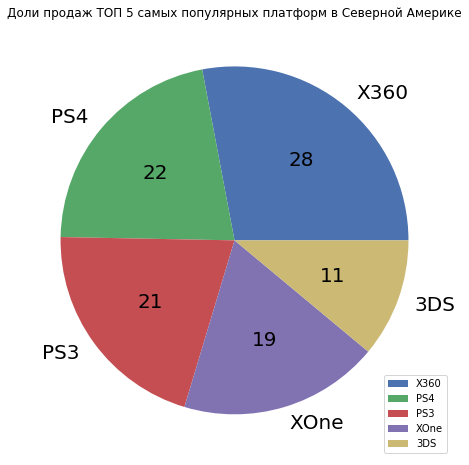

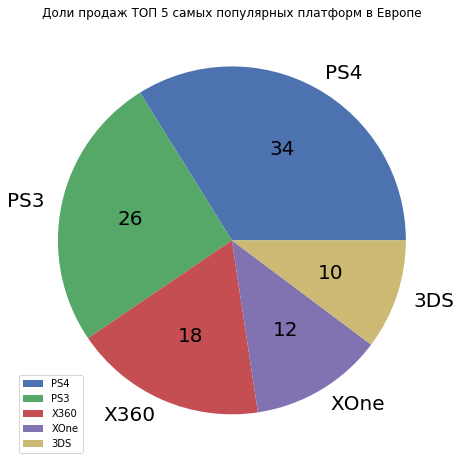

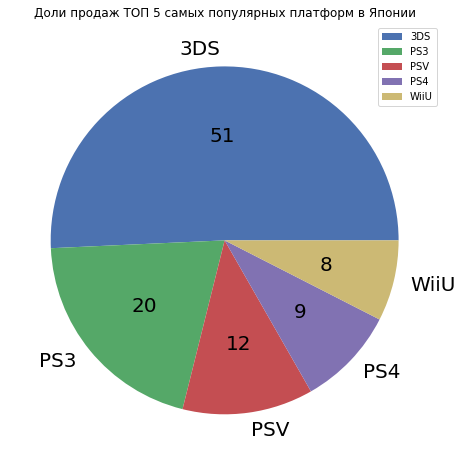

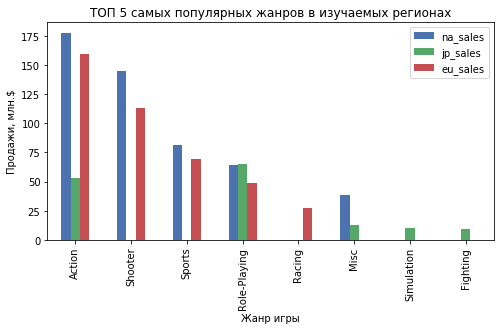

In [40]:
na_sales = games_analyze.groupby('platform').agg({'na_sales':'sum'}).\
sort_values(by = 'na_sales', ascending = False).\
head(5)
na_sales['na_ratio'] = na_sales['na_sales']/sum(na_sales['na_sales'])
na_sales.plot(y = 'na_ratio', kind = 'pie', figsize=(8, 8), autopct='%.0f', fontsize=20)
plt.title("Доли продаж ТОП 5 самых популярных платформ в Северной Америке")
plt.ylabel('')
plt.show()


eu_sales = games_analyze.groupby('platform').agg({'eu_sales':'sum'}).\
sort_values(by = 'eu_sales', ascending = False).\
head(5)
eu_sales['eu_ratio'] = eu_sales['eu_sales']/sum(eu_sales['eu_sales'])
eu_sales.plot(y = 'eu_ratio', kind = 'pie', figsize=(8, 8), autopct='%.0f', fontsize=20)
plt.title("Доли продаж ТОП 5 самых популярных платформ в Европе")
plt.ylabel('')
plt.show()

jp_sales = games_analyze.groupby('platform').agg({'jp_sales':'sum'}).\
sort_values(by = 'jp_sales', ascending = False).\
head(5)
jp_sales['jp_ratio'] = jp_sales['jp_sales']/sum(jp_sales['jp_sales'])
jp_sales.plot(y = 'jp_ratio', kind = 'pie', figsize=(8, 8), autopct='%.0f', fontsize=20)
plt.title("Доли продаж ТОП 5 самых популярных платформ в Японии")
plt.ylabel('')
plt.show()


na = games_analyze.groupby('genre').agg({'na_sales':'sum'}).sort_values(by = 'na_sales', ascending = False).\
head(5)
eu = games_analyze.groupby('genre').agg({'eu_sales':'sum'}).sort_values(by = 'eu_sales', ascending = False).\
head(5)
jp = games_analyze.groupby('genre').agg({'jp_sales':'sum'}).sort_values(by = 'jp_sales', ascending = False).\
head(5)
region_sales_genre = eu.merge(jp, on = 'genre', how = 'outer')
region_sales_genre = region_sales_genre.merge(na, on = 'genre', how = 'outer')
region_sales_genre.plot(y = ['na_sales','jp_sales','eu_sales'], kind = 'bar', figsize=(8, 4))
plt.title("ТОП 5 самых популярных жанров в изучаемых регионах")
plt.ylabel('Продажи, млн.$')
plt.xlabel('Жанр игры')
plt.show()


<div style="border:solid  red  1px; padding: 5px"> 

### Вывод по ТОП 5 платформам
    
В Америке нет большой разницы в долях продаж по платформам:
- Лидером является `X360` c долей *28 %*, `PS4`, `PS3`, `Xone` в среднем с долей *20 %*
- В хвосте   `3Ds` - *11 %*
    
В Европе разница в долях между платформами лидерами больше, чем в Америке:
- Лидером является `PS4` c долей *34 %*, `PS3` - *26 %*, `X360` - *18 %*, 
- В хвосте `Xone`-*12 %* и  `3Ds` - *10 %*
    
В Японии имеется платформа, доля которой ощутимо превышает остальные:
- Лидером является `3Ds` c долей *34 %*, далее `PS3` - *20 %* 
- В хвосте `Psv`-*12 %*,`PS4` - *9 %*, `WiiU` - *8*%
    
Таким образом, платформа `3Ds`, которая наименее популярна в Америке и Европе, доминирует в Японии

Платформа `PS4` одна из наименее популярных в Японии, в числе самых популярных в Европе и Америке

<div style="border:solid  red  1px; padding: 5px"> 
 
### Вывод по ТОП 5 жанрам
    
В качестве жанров предпочтения Японцев так же отличаются от Европейцев и Американцев:
- в Японии доминирует `Role-Playing`, который в других регионах лишь на предпоследнем месте, а жанры `Simulation` и `Fightning` входят в топ лишь этой страны
- В Америке 5 место принадлежит жанру `Misc`, а в Европе - `Racing`, в остальном их рейтинги совпали

,na_sales,eu_sales,jp_sales
rating,,,
0+,114.37,113.03,28.33
10+,66.02,52.96,26.02
13+,231.57,193.96,21.20


,na_sales,eu_sales,jp_sales
rating,,,
0+,114.37,113.03,28.33
10+,66.02,52.96,26.02
13+,231.57,193.96,21.20


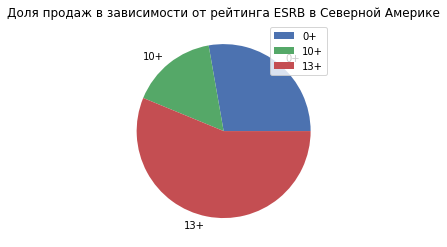

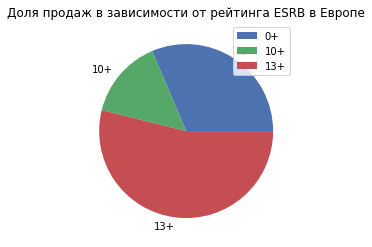

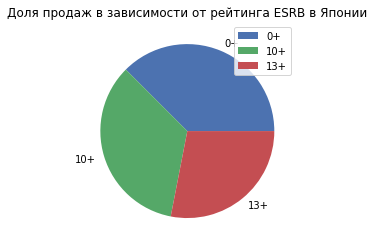

In [41]:
esrb_analyze = games_analyze.groupby('rating').agg({'na_sales':'sum',
                                                    'eu_sales':'sum',
                                                    'jp_sales':'sum'})
display(esrb_analyze)
esrb_analyze.plot(y = 'na_sales', kind = 'pie')
plt.ylabel('')
plt.title("Доля продаж в зависимости от рейтинга ESRB в Северной Америке")
esrb_analyze.plot(y = 'eu_sales', kind = 'pie')
plt.ylabel('')
plt.title("Доля продаж в зависимости от рейтинга ESRB в Европе")
esrb_analyze.plot(y = 'jp_sales', kind = 'pie')
plt.ylabel('')
plt.title("Доля продаж в зависимости от рейтинга ESRB в Японии")
display(esrb_analyze)

<div style="border:solid  red  1px; padding: 5px"> 

Исходя из полученных круговых диаграмм, можно сделать вывод, что рейтинг ESRB влияет только на Северную Америку и Европу, причём в примерно в равной степени. А в Японии данный рейтинг не влияет на сумму продаж   

In [42]:
alpha = 0.05
xOne = games_analyze[games_analyze['user_score'].isna()==False].query('platform == "XOne"').head(500)
PC =  games_analyze[games_analyze['user_score'].isna()==False].query('platform == "PC"').head(500)
platform_mesure = st.ttest_ind(xOne['user_score'], PC['user_score'],equal_var = True)
print('p-значение:', platform_mesure.pvalue)
if (platform_mesure.pvalue < alpha):
    print()
    print("Отвергаем нулевую гипотезу")
else:
    print()
    print("Не получилось отвергнуть нулевую гипотезу,значит нулевая гипотеза:")
    print('"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - верна')

Action = games_analyze[games_analyze['user_score'].isna()==False].query('genre == "Action"').head(500)
Sports =  games_analyze[games_analyze['user_score'].isna()==False].query('genre == "Sports"').head(500)
sports_mesure = st.ttest_ind(Action['user_score'], Sports['user_score'],equal_var = True)
print()
print()
print('p-значение:', sports_mesure.pvalue)
if (sports_mesure.pvalue < alpha):
    print()
    print('Отвергаем нулевую гипотезу,значит альтернативная гипотеза:')
    print('"Средние пользовательские рейтинги жанров Action и Sports разные" - верна')
else:
    print("Не получилось отвергнуть нулевую гипотезу")    

p-значение: 0.5535080500643661

Не получилось отвергнуть нулевую гипотезу,значит нулевая гипотеза:
"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - верна


p-значение: 1.7125892626406896e-26

Отвергаем нулевую гипотезу,значит альтернативная гипотеза:
"Средние пользовательские рейтинги жанров Action и Sports разные" - верна


### Вывод

- акутальный период исчезновения старых и появления новых платформ примерно **5 лет**
- на момент исследования данных можно наблюдать исчезновение платформ   *PS3,Wii,X360* , которые входят в список топ 5 самых продаваемых за всю историю
- самые перспективные по продажам за последние 5 лет -  платформы *PS4 XOne 3DS* тоже идут на спад, но исходя из графика зафисимости количества продаж, наиболее прибыльной в 2017 году будет платформа *PS4*
- для самой продаваемой в 2016 году платформы *PS4*  зависимость между экспертной оценкой и количеством продаж слабая, а между оценкой пользователей практически отсутсвует
- Япония - это страна, в которой предпочтения пользователей отличаются и по платформам и по жанрам, разницу и рейтинг ТОП 5 можно увидеть в выводых выше

Было проверено 2 гипотезы, по итогу:
- гипотеза :"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - **верна**(нулевая)
- гипотеза :"Средние пользовательские рейтинги жанров Action и Sports разные" - **верна**(альтернативная)